In [89]:
import pandas as pd
from curl_cffi import requests
import sqlite3
from dataclasses import dataclass
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
headers = {
     'Accept': 'application/json, text/plain, */*',
     'Accept-Encoding': 'gzip, deflate, br, zstd',
     'Referer':'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/%D0%BA%D0%B0%D1%82%D0%B0%D0%BB%D0%BE%D0%B3-%D0%BD%D0%BE%D0%B2%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BA/%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82/60683',
     'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36'
                }

In [67]:
@dataclass
class Obj_inf:
    """Информация об объектах, выгрузка кол-ва объектов передается при создании класса, при выгрузке всех объетов вызвать метод get_total"""
    offset=0
    limit=100
    data = None
    list_obj = []
    total:int
    url =f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={0}&limit={1}&sortField=obj_publ_dt&sortType=desc&residentialBuildings=1&objStatus=0' 
    
    def get_total(self):
        """Выгрузка общего количества объектов"""
        res = requests.get(url = self.url, headers= headers, impersonate= 'chrome116')
        if res.status_code==200:
            self.total = res.json()['data']['total']
            return self.total
    
    def get_list_id(self):
        """Выгрузка списка объектов и извлечения id в список"""
        while True:
            self.url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset}&limit={self.limit}&sortField=obj_publ_dt&sortType=desc&residentialBuildings=1&objStatus=0' 
            res = requests.get(url = self.url, headers= headers, impersonate= 'chrome116')
            self.data = res.json()['data']['list']
            obj = [i.get('objId') for i in tqdm(self.data)]
            self.list_obj.extend(obj)
            self.offset+=100
            if len(self.list_obj) >= self.total:
                return self.list_obj
                
    def __len__(self):
        return len(self.list_obj)
    

In [68]:
@dataclass
class Data_Obj:
    ids:list
    url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/'

    data = pd.DataFrame()
    
    def get_data(self):
        """Выгрузка информации по каждому объекту"""
        for i in tqdm(self.ids):
            res = requests.get(url = self.url+str(i), headers= headers, impersonate ='chrome116')
            self.data = pd.concat([self.data,  pd.json_normalize(res.json())])
        self.data = self.data.reset_index().drop('index', axis= 1)
        return self.data
    
    def save_to_exl(self):
        """Сохранение в эксель"""
        pd.DataFrame.to_excel(self.data, 'data.xlsx',index=False)
        
    
    def save_to_pkl(self):
        """Сохранение в pickle"""
        pd.DataFrame.to_pickle(self.data, 'data.pkl')   
    
    
    def save_to_bd(self):
        """Сохранение в БД"""
        conn = sqlite3.connect('test_database')
        self.data.iloc[:,:15].to_sql('products', conn, if_exists='replace', index = False)
        conn.commit()
        conn.close()

In [69]:
b = Obj_inf(100)

In [72]:
#b.get_total()

c = b.get_list_id()


11408

In [71]:
#Для теста взято пару значений из списка.
a = Data_Obj(c[:3])
a.get_data()
a.save_to_exl()
a.save_to_pkl()
a.save_to_bd()

  0%|          | 0/3 [00:00<?, ?it/s]

In [206]:
class Plot_Creator:
    def __init__(self,data = None):
        pass
    
    def load_data(self):
        self.data = pd.read_pickle('Hometask.pkl')
        
    def prep_data(self):
        region = pd.read_excel('region.xlsx')
        id_to_name = region.set_index('id').to_dict()['name']
        self.data['reg'] = self.data['region'].map(id_to_name)
        #Наличие метро
        self.data['metro'] = self.data['metro.id'].fillna(-1).map(lambda x: 'Y' if float(x) > 0 else 'N' )
        #Год постройки
        self.data['objrdyear'] = pd.to_datetime(self.data.objReady100PercDt).dt.year
        cols = ['reg','objPriceAvg','objFloorCnt','objSquareLiving','objFlatCnt','objElemParkingCnt','metro','objrdyear','wallMaterialShortDesc']
        self.data = self.data[cols]
        
        return self.data
        
    
    def pie(self,labels, size = (15,15),pctd= 1.1,labeld= 1.2):
        df = self.data.groupby(labels).size().reset_index(name ='count')
        
        plt.figure(figsize= size, facecolor = 'White')
        #plt.style.use('dark_background')
        plt.pie(x = df['count'],
        labels = df[labels],
        startangle= 25,
        autopct='%.0f%%',
        pctdistance= pctd,
        labeldistance= labeld,
        rotatelabels= True,
        counterclock= False,
        wedgeprops={'edgecolor':'black'})
        plt.tight_layout()
        plt.title(f'Доля {labels}')
        plt.show()
    
    def plot(self, col , size = (10,15), log = True):
        """Countplot , выбираем столбец и размер при необходимости"""
        plt.figure(figsize=(size))
        sns.countplot(
        y = col,
        orient= 'v',
        data= self.data,
        log = log)
        plt.title(col)
        plt.tight_layout()
        plt.show()
        
        
    def boxplot(self, reg_name = None):
        col = ['objFloorCnt','objSquareLiving','objFlatCnt','objElemParkingCnt']
        plt.figure(figsize=(15,15))
        for idx, feature in enumerate(col, 1):
            plt.subplot(2, 2, idx)
            sns.boxplot(
        y = 'reg',
        x = feature,
        hue = 'reg',
        order = reg_name,
        data = self.data.query(f'reg in {reg_name}'))
        plt.title(f"{feature}")
        plt.tight_layout()
        plt.show()

In [207]:
n = Plot_Creator()

n.load_data()

y = n.prep_data()

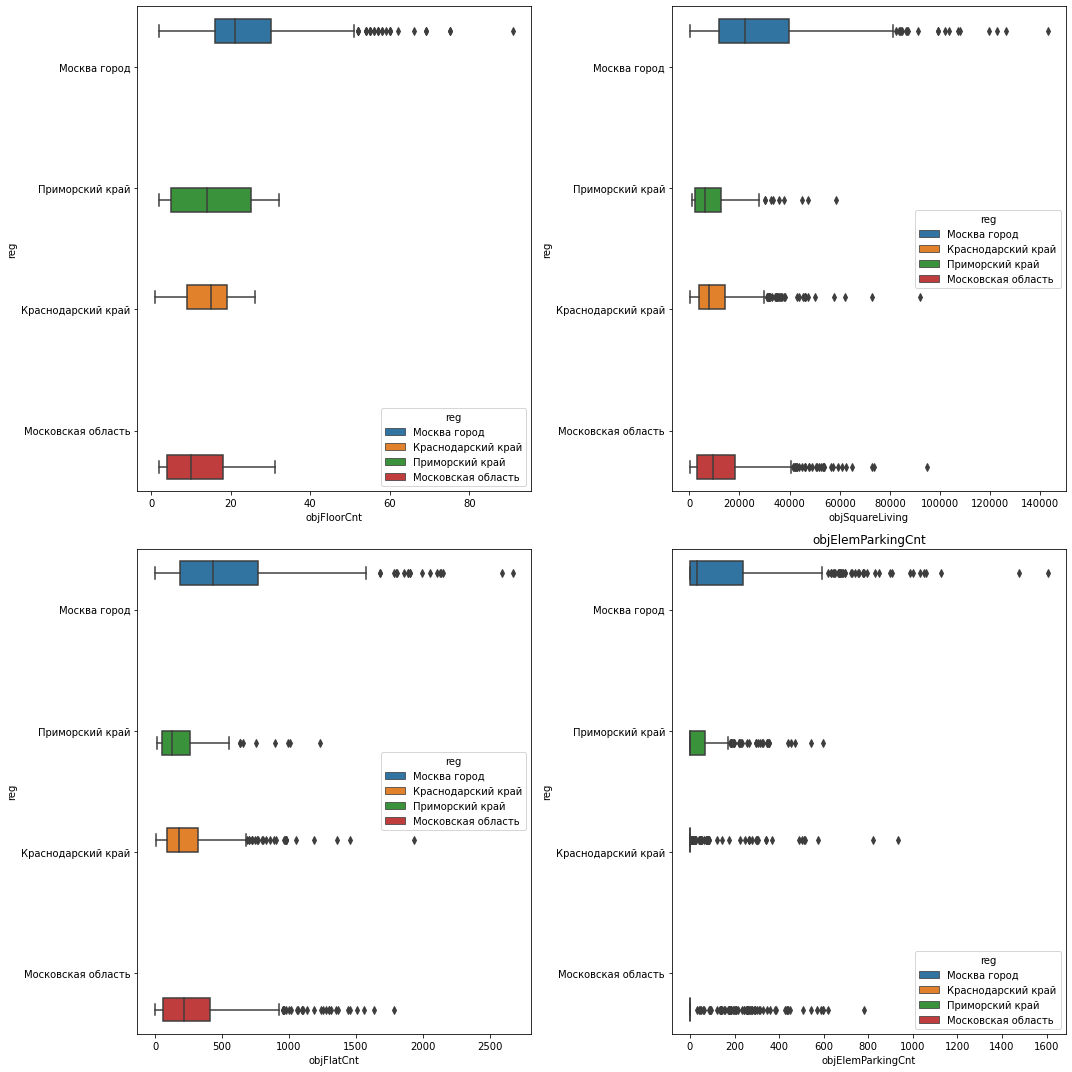

In [210]:
n.boxplot(['Москва город','Приморский край','Краснодарский край','Московская область'])

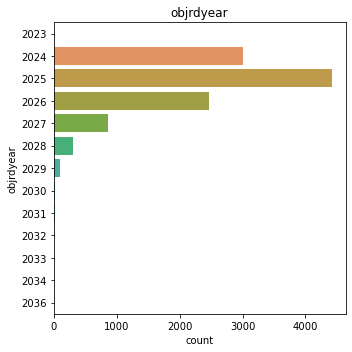

In [188]:
n.plot('objrdyear', size = (5,5),log = False)

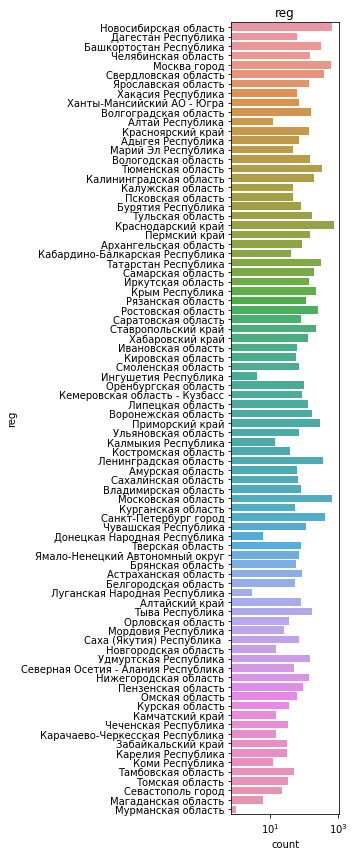

In [146]:
n.plot('reg', size = (5,12))

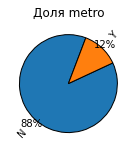

In [191]:
n.pie('metro', (2,2))

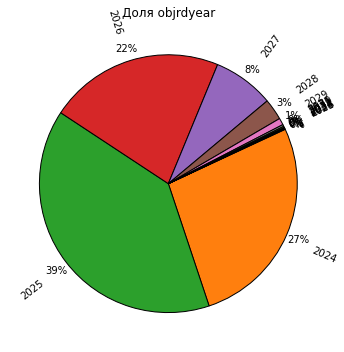

In [180]:
n.pie('objrdyear', (5,5))

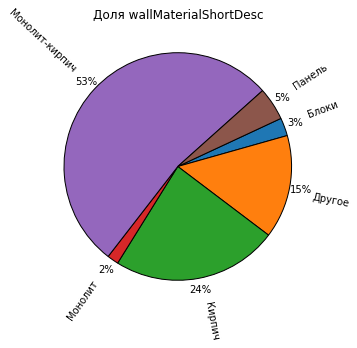

In [182]:
n.pie('wallMaterialShortDesc', (5,5))

In [209]:
y

,reg,objPriceAvg,objFloorCnt,objSquareLiving,objFlatCnt,objElemParkingCnt,metro,objrdyear,wallMaterialShortDesc
0,Новосибирская область,NaN,2,100.30,1,0,N,2026,Другое
0,Новосибирская область,NaN,2,100.30,1,0,N,2026,Другое
0,Новосибирская область,NaN,2,100.30,1,0,N,2026,Другое
0,Новосибирская область,NaN,2,100.30,1,0,N,2026,Другое
0,Новосибирская область,NaN,2,100.30,1,0,N,2026,Другое
...,...,...,...,...,...,...,...,...,...
0,Краснодарский край,152598.0,20,22542.49,466,0,N,2025,Монолит-кирпич
0,Краснодарский край,161747.0,19,15549.30,321,0,N,2025,Монолит-кирпич
0,Краснодарский край,133803.0,25,11914.25,207,0,N,2025,Монолит-кирпич
0,Москва город,NaN,28,45733.40,1115,0,Y,2024,Блоки
